### EDA on Vessel Size

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
ais_tracks_path = '../data/tracks_ais.csv'
radar_tracks_path = '../data/tracks_radar.csv'
radar_detections_path = '../data/detections_radar.csv'
tagged_detections_path = '../data/detections_tagged.csv'
tracks_tagged_path = '../data/tracks_tagged.csv'

ais_tracks = pd.read_csv(ais_tracks_path)
radar_tracks = pd.read_csv(radar_tracks_path)
radar_detections = pd.read_csv(radar_detections_path)
tagged_detections = pd.read_csv(tagged_detections_path)
tracks_tagged = pd.read_csv(tracks_tagged_path)

print("Length of ais_tracks:", len(ais_tracks))
print("Length of radar_tracks:", len(radar_tracks))
print("Length of radar_detections:", len(radar_detections))
print("Length of tagged_detections:", len(tagged_detections))
print("Length of tracks_tagged:", len(tracks_tagged))

Length of ais_tracks: 27416
Length of radar_tracks: 27416
Length of radar_detections: 7387790
Length of tagged_detections: 6756272
Length of tracks_tagged: 9013


In [19]:
ais_tracks['length'] = ais_tracks['dim_a'] + ais_tracks['dim_b']
ais_tracks['width'] = ais_tracks['dim_c'] + ais_tracks['dim_d']
ais_tracks['area'] = ais_tracks['length'] * ais_tracks['width']

#Filter only the AIS tracks with valid size information
ais_tracks_with_size = ais_tracks.dropna(subset=['width', 'length'])
length_width_filter = (ais_tracks['length'] > 0) & (ais_tracks['width'] > 0)
ais_tracks_with_size = ais_tracks_with_size[length_width_filter]
print(f'Total number of AIS tracks with size info: {len(ais_tracks_with_size)}')

Total number of AIS tracks with size info: 21979


/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_79923/243119626.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ais_tracks_with_size = ais_tracks_with_size[length_width_filter]


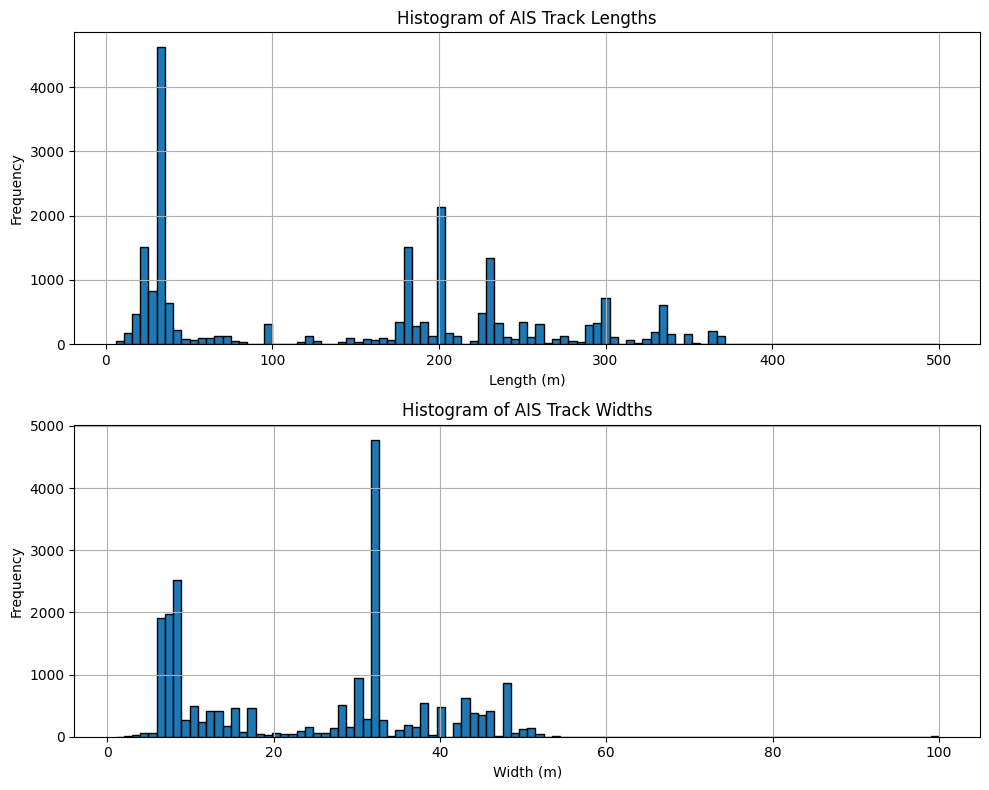

In [20]:
# Create a figure with two subplots
plt.figure(figsize=(10,8))

# Plot histogram for length
plt.subplot(2, 1, 1)
ais_tracks_with_size['length'].hist(bins=100, edgecolor='black')
plt.title('Histogram of AIS Track Lengths')
plt.xlabel('Length (m)')
plt.ylabel('Frequency')

# Plot histogram for width
plt.subplot(2, 1, 2)
ais_tracks_with_size['width'].hist(bins=100, edgecolor='black')
plt.title('Histogram of AIS Track Widths')
plt.xlabel('Width (m)')
plt.ylabel('Frequency')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
from utilities import VesselTypeAggregator

vessel_type_aggregator = VesselTypeAggregator()
vessel_type_aggregator.aggregate_vessel_type(ais_tracks_with_size)
ais_tracks_with_size['type_m2_agg'].value_counts()

type_m2_agg
cargo/tanker      11673
passenger_ship     3855
other              3040
tug/tow            1782
military_ship       776
pleasure_craft      587
fishing_boat        266
Name: count, dtype: int64

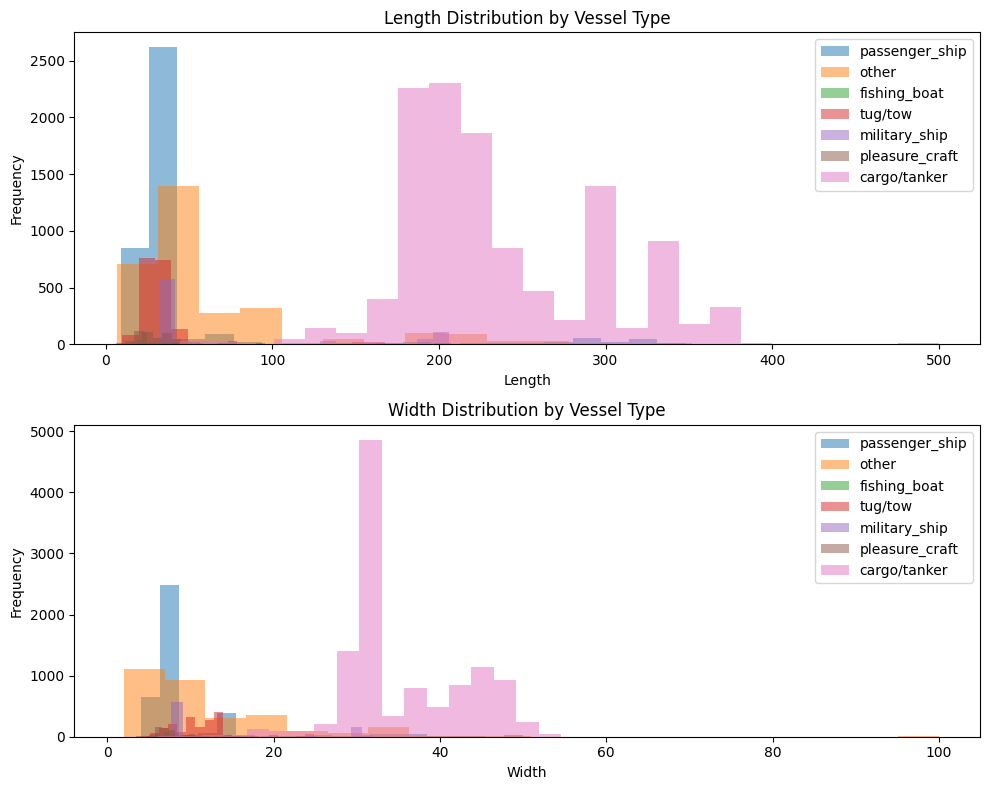

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size for a vertical layout
plt.figure(figsize=(10, 8))

# Create a subplot for length
plt.subplot(2, 1, 1)
for vessel_type in ais_tracks_with_size['type_m2_agg'].unique():
    subset = ais_tracks_with_size[ais_tracks_with_size['type_m2_agg'] == vessel_type]
    plt.hist(subset['length'], bins=20, alpha=0.5, label=vessel_type)
plt.title('Length Distribution by Vessel Type')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()

# Create a subplot for width
plt.subplot(2, 1, 2)
for vessel_type in ais_tracks_with_size['type_m2_agg'].unique():
    subset = ais_tracks_with_size[ais_tracks_with_size['type_m2_agg'] == vessel_type]
    plt.hist(subset['width'], bins=20, alpha=0.5, label=vessel_type)
plt.title('Width Distribution by Vessel Type')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

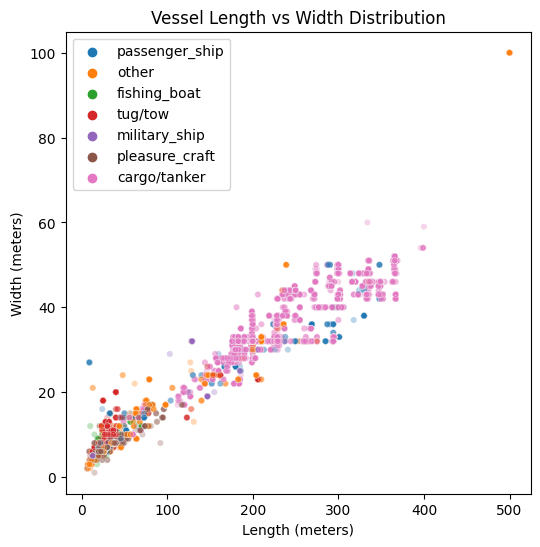

In [23]:

# Create the scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=ais_tracks_with_size, x='length', y='width', alpha=0.3, hue = 'type_m2_agg', s = 20)

# Add labels and title
plt.xlabel('Length (meters)')
plt.ylabel('Width (meters)')
plt.title('Vessel Length vs Width Distribution')
plt.legend()
plt.show()

In [24]:
corr = ais_tracks_with_size['length'].corr(ais_tracks_with_size['width'])
print(f'Correlation between length and width: {round(corr, 2)}')

Correlation between length and width: 0.97


In [25]:
features_subset = ['min_speed', 'max_speed', 'avg_speed', 'curviness', 
                   'heading_mean', 'heading_std', 'turning_mean', 'turning_std', 
                   'duration_z', 'distance', 'distance_o']

for feature in features_subset:
    corr = ais_tracks_with_size['area'].corr(ais_tracks_with_size[feature])
    print(f'Correlation between area and {feature}: {round(corr, 2)}')

Correlation between area and min_speed: 0.38
Correlation between area and max_speed: 0.0
Correlation between area and avg_speed: 0.35
Correlation between area and curviness: -0.2
Correlation between area and heading_mean: -0.04
Correlation between area and heading_std: -0.32
Correlation between area and turning_mean: -0.35
Correlation between area and turning_std: -0.36
Correlation between area and duration_z: 0.27
Correlation between area and distance: -0.02
Correlation between area and distance_o: 0.01


In [26]:
import statsmodels.api as sm

results = []

for feature in features_subset:
    X = ais_tracks_with_size[[feature]] #X is 2D
    X = sm.add_constant(X)  # Adds intercept term (b)
    y = ais_tracks_with_size['area']

    nan_mask = X[feature].isna()
    y = y[~nan_mask]
    X = X[~nan_mask]
    
    model = sm.OLS(y, X).fit()
    
    coef_a = model.params[feature]
    p_value_a = model.pvalues[feature]
    
    results.append({
        'feature': feature,
        'coef_a': coef_a,
        'p_value_a': p_value_a,
        'r_squared': model.rsquared
    })


coeff_df = pd.DataFrame(results)

# Format: round to 3 decimal places, set anything < 0.001 to 0
def custom_format(x):
    return 0 if abs(x) < 0.001 else round(x, 3)

for col in ['coef_a', 'p_value_a', 'r_squared']:
    coeff_df[col] = coeff_df[col].map(custom_format)

print(coeff_df)


         feature    coef_a  p_value_a  r_squared
0      min_speed   389.957      0.000      0.143
1      max_speed     2.185      0.588      0.000
2      avg_speed   421.587      0.000      0.119
3      curviness  -751.368      0.000      0.040
4   heading_mean    -1.854      0.000      0.002
5    heading_std -2147.552      0.000      0.100
6   turning_mean  -110.511      0.000      0.121
7    turning_std   -69.570      0.000      0.126
8     duration_z     0.320      0.000      0.074
9       distance    -0.014      0.013      0.000
10    distance_o     0.207      0.078      0.000


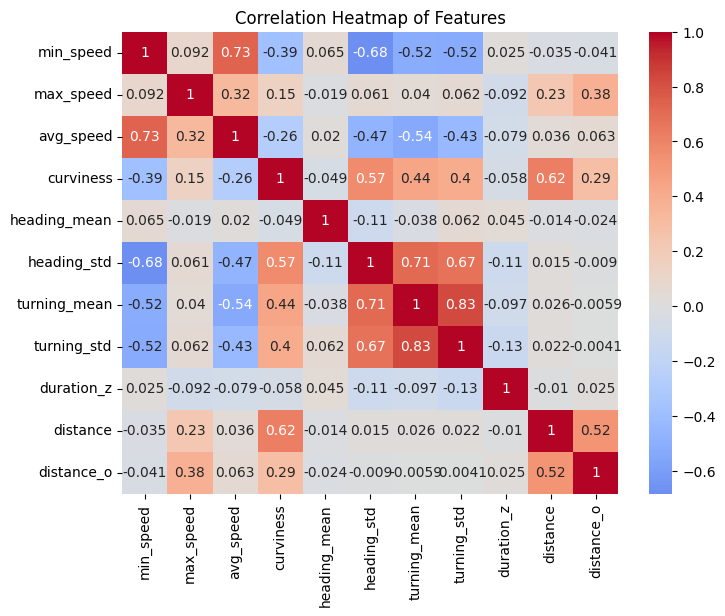

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(ais_tracks_with_size[features_subset].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()


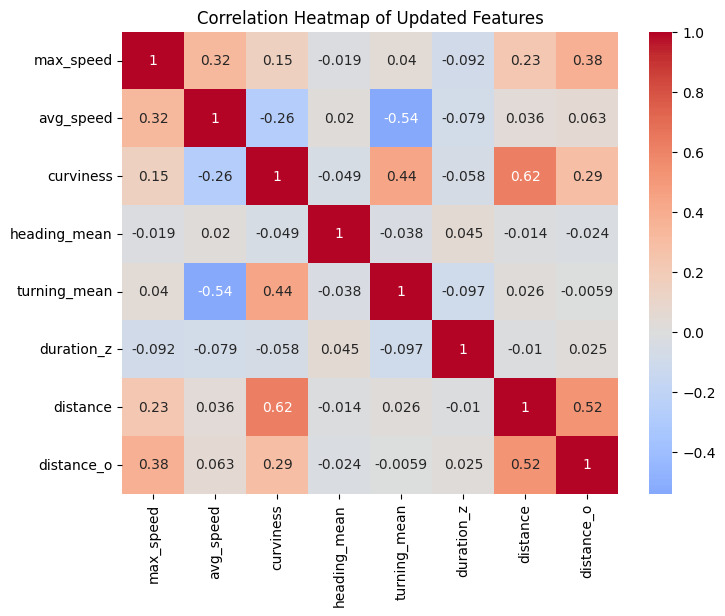

In [30]:
removed_features = ['min_speed', 'turning_std', 'heading_std']
updated_features = [feature for feature in features_subset if feature not in removed_features]

plt.figure(figsize=(8, 6))
sns.heatmap(ais_tracks_with_size[updated_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Updated Features')
plt.show()


In [31]:
### Fit a full linear model using non-highly correlated features

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

X = ais_tracks_with_size[updated_features]
y = ais_tracks_with_size['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}, R-squared: {r2}')

MSE: 19567469.851743486, R-squared: 0.23577222407376386


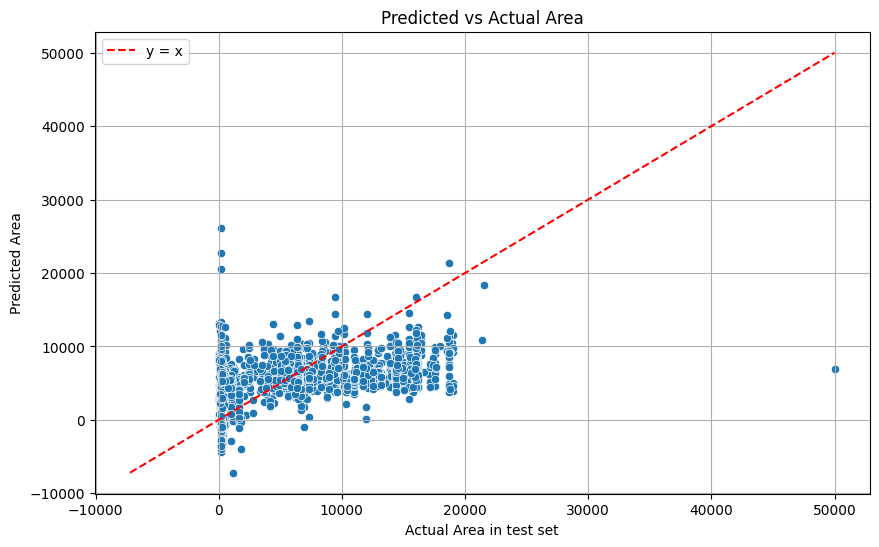

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)

# Get min and max values for the y = x reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')

plt.xlabel('Actual Area in test set')
plt.ylabel('Predicted Area')
plt.title('Predicted vs Actual Area')
plt.legend()
plt.grid(True)
plt.show()


#### Quantile Regression?